### This is a toy notebook that will always work (and give confidence to the user)

In [13]:
from ortools.sat.python import cp_model
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


### Create the JobPartialSolutionPrinter which helps to print all the solutions. The last will be optimal

In [14]:
class JobPartialSolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions, including total assignments per member."""

    def __init__(self, shifts, all_members, num_weeks, all_jobs, total_assignments):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self._shifts = shifts
        self._all_members = all_members
        self._num_weeks = num_weeks
        self._all_jobs = all_jobs
        self._solution_count = 0
        self._total_assignments = total_assignments  # Track total assignments

    def on_solution_callback(self):
        self._solution_count += 1
        print(f"\nSolution {self._solution_count}")

        # Print the solution table
        solution_df = pd.DataFrame()
        solution_df["Job"] = self._all_jobs
        for w in range(self._num_weeks):
            week_list = []
            for j in self._all_jobs:
                job_filled = False
                for m in self._all_members:
                    if self.Value(self._shifts[(m, w, j)]):
                        week_list.append(m)
                        job_filled = True
                if not job_filled:
                    week_list.append(np.nan)
            solution_df[f"Week {w}"] = week_list
        display(solution_df)

        # Collect assignment counts
        assignment_counts = [self.Value(self._total_assignments[m]) for m in self._all_members]

        # Convert to DataFrame
        df = pd.DataFrame(assignment_counts, columns=["Total Assignments"])

        # Create a cleaner discrete histogram
        plt.figure(figsize=(10, 6))
        ax = sns.histplot(df["Total Assignments"], binwidth=1, discrete=True, kde=False, color="royalblue", edgecolor="black")

        # Labels and title
        plt.xlabel("Total Assignments", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.title("Total Assignments per Member", fontsize=14)

        # Annotate count on top of each bar (optional)
        for p in ax.patches:
            ax.annotate(f"{int(p.get_height())}", (p.get_x() + 0.5, p.get_height()), ha="center", va="bottom", fontsize=10)

        plt.show()  


    def solution_count(self):
        return self._solution_count


### Generate the toy dataset. We have some jobs which are important and some which are not. We simulate the dataset of availability and also the dataset of skills

In [15]:
NUM_WEEKS = 13
all_members = ['Jeff', 'John', 'Jill', 'Jack', 'whee', 'mary']
all_jobs = ['Guitar', 'Piano', 'Leader', 'Waterboy']
must_have_jobs = ['Guitar', 'Piano', 'Leader']
not_must_have_jobs = ['Waterboy']
all_weeks = [i for i in range(NUM_WEEKS)]
input_col_names = ['name'] + all_weeks

# Simulate availability constraints (some members are unavailable on some weeks)

simulated_availability = [[True if random.random() > 0.05 else False for _ in all_weeks] for _ in all_members]
availability_df = pd.DataFrame(simulated_availability, columns=(all_weeks), index=all_members)

simulated_skills = [[True if random.random() > 0.5 else False for _ in all_jobs] for _ in all_members]
skills_df = pd.DataFrame(simulated_skills, columns=(all_jobs), index=all_members)

display(availability_df)
display(skills_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12
Jeff,True,True,True,True,True,True,True,True,True,True,True,True,False
John,True,True,True,False,True,True,True,True,True,True,True,True,True
Jill,True,True,True,True,True,True,True,True,True,True,True,True,True
Jack,True,True,True,True,True,True,True,True,True,True,True,True,True
whee,True,True,True,True,True,True,True,True,True,True,True,True,True
mary,True,True,True,True,True,False,True,True,True,True,True,False,True


,Guitar,Piano,Leader,Waterboy
Jeff,False,True,False,False
John,True,True,False,False
Jill,False,True,True,True
Jack,True,False,False,True
whee,False,True,True,True
mary,False,False,False,False


### The model has the following constraints (updated 02/03/2025)

- Each crucial job is assigned to only 1 member
- Each non-crucial job is assigned to at most one member per week.
- Each member does at most one job per week.
- Availability constraints
- Skill constraints
- Add constraint that members cannot be rostered thrice in a row

### The model optimises the following (updated 02/03/2025)
- Maximise the total assignments across the board
- Minimise variance in assignments per person


Solution 1


,Job,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12
0,Guitar,John,John,Jack,Jack,John,Jack,Jack,John,Jack,Jack,John,Jack,Jack
1,Piano,Jeff,Jill,John,Jeff,Jill,John,John,Jill,John,John,Jill,John,John
2,Leader,Jill,whee,Jill,Jill,whee,Jill,Jill,whee,Jill,Jill,whee,Jill,Jill
3,Waterboy,whee,Jack,whee,whee,Jack,whee,whee,Jack,whee,whee,Jack,whee,whee


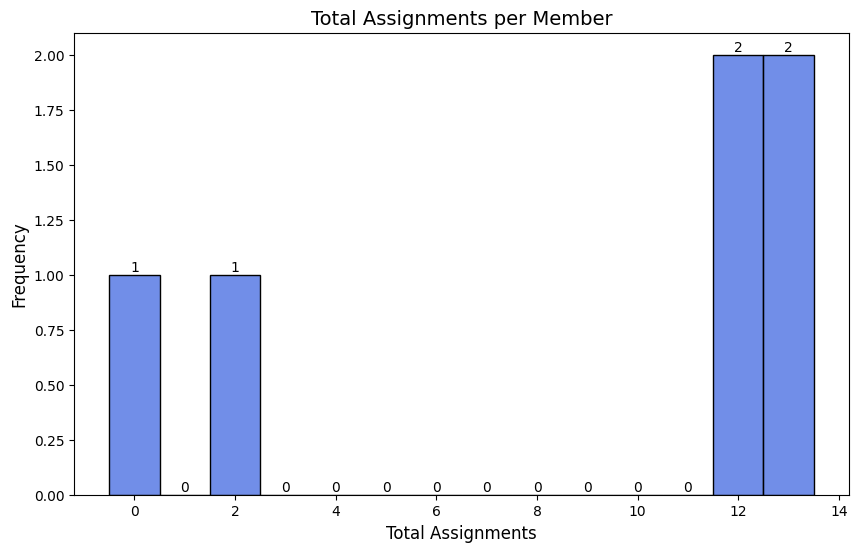


Solution 2


,Job,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12
0,Guitar,Jack,Jack,John,Jack,John,Jack,John,Jack,Jack,John,John,Jack,Jack
1,Piano,Jeff,Jill,Jeff,Jeff,Jill,Jeff,Jeff,Jill,John,Jeff,Jeff,John,John
2,Leader,Jill,whee,whee,Jill,whee,whee,Jill,whee,Jill,whee,Jill,whee,whee
3,Waterboy,NaN,NaN,Jack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jack,NaN,NaN


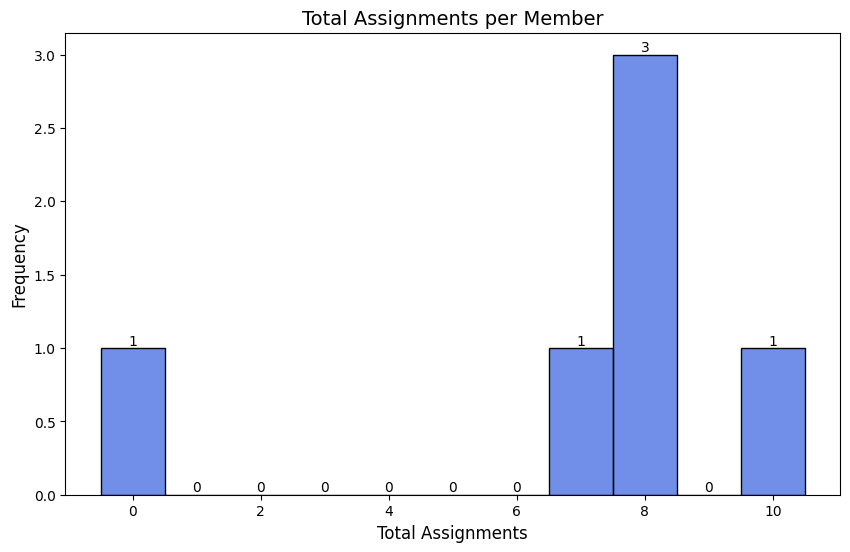


Solution 3


,Job,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12
0,Guitar,Jack,John,John,Jack,Jack,John,Jack,John,Jack,John,John,Jack,Jack
1,Piano,Jill,Jeff,Jeff,whee,Jeff,Jeff,Jill,Jeff,Jeff,Jill,Jeff,Jeff,John
2,Leader,whee,whee,Jill,Jill,whee,Jill,whee,Jill,whee,whee,Jill,Jill,whee
3,Waterboy,NaN,Jill,whee,NaN,NaN,Jack,NaN,NaN,Jill,NaN,whee,whee,Jill


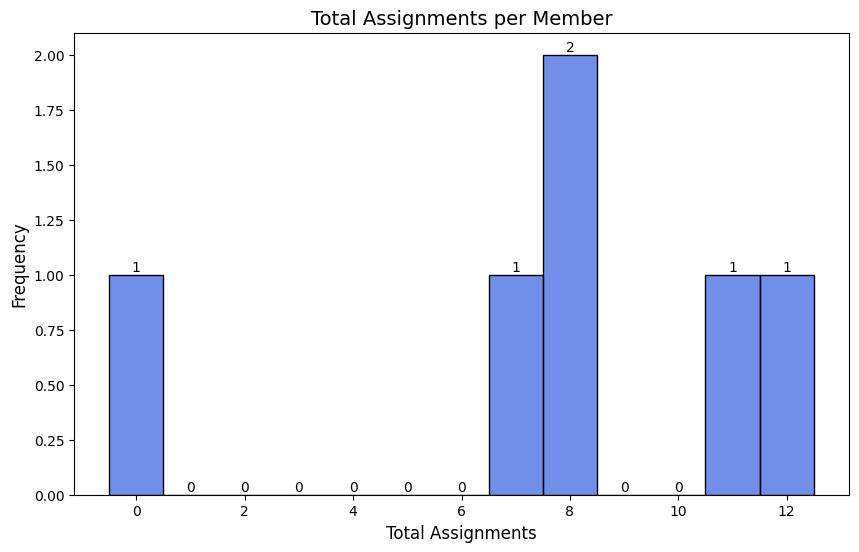


Solution 4


,Job,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12
0,Guitar,Jack,John,John,Jack,Jack,John,Jack,John,Jack,John,John,Jack,Jack
1,Piano,John,Jeff,Jeff,whee,Jeff,Jeff,Jill,Jeff,Jeff,Jill,Jeff,Jeff,John
2,Leader,whee,whee,Jill,Jill,whee,Jill,whee,Jill,whee,whee,Jill,Jill,whee
3,Waterboy,NaN,Jill,whee,NaN,NaN,Jack,NaN,NaN,Jill,NaN,whee,whee,Jill


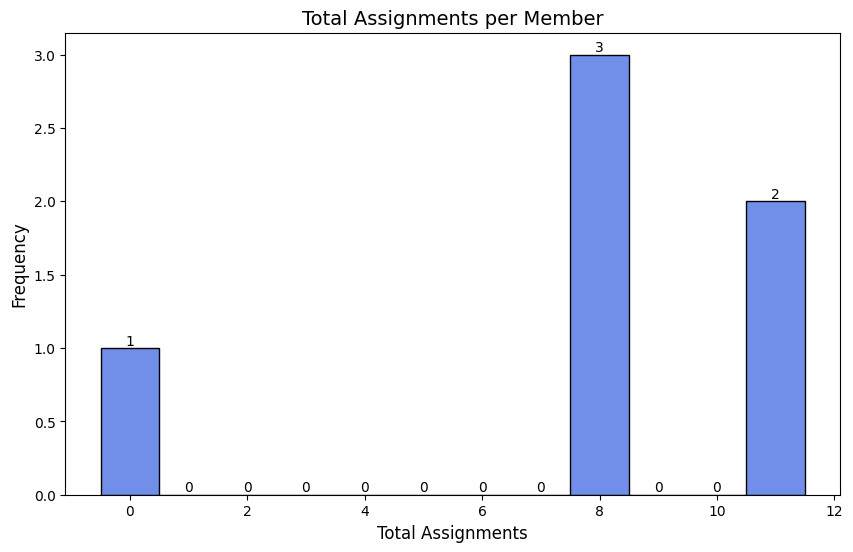


Solution 5


,Job,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12
0,Guitar,John,John,Jack,Jack,John,John,Jack,John,John,Jack,John,John,Jack
1,Piano,Jeff,Jeff,John,Jeff,Jeff,Jill,Jeff,Jeff,Jill,Jeff,Jeff,Jill,John
2,Leader,Jill,Jill,whee,Jill,Jill,whee,Jill,Jill,whee,Jill,Jill,whee,Jill
3,Waterboy,Jack,Jack,Jill,whee,Jack,Jack,whee,Jack,Jack,whee,Jack,Jack,whee


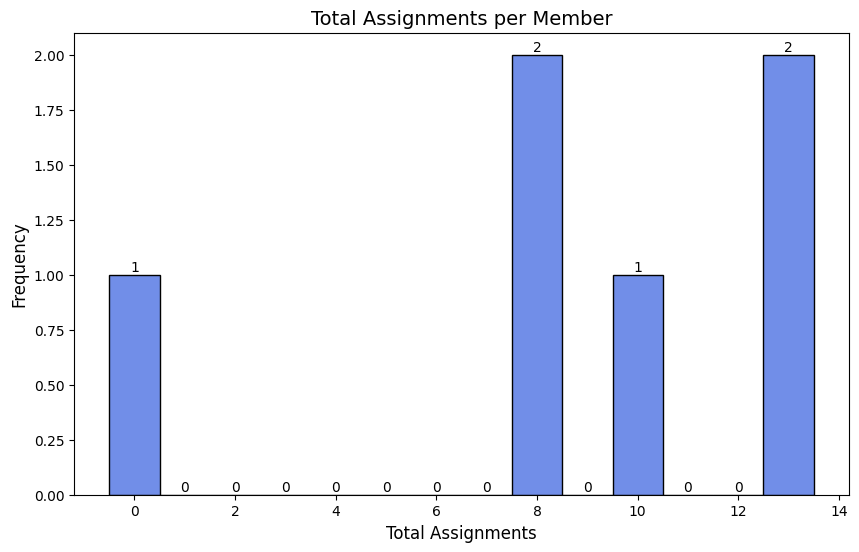


Solution 6


,Job,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12
0,Guitar,John,John,Jack,Jack,John,Jack,John,John,Jack,John,Jack,John,John
1,Piano,whee,Jeff,John,Jeff,Jeff,John,Jeff,Jeff,John,Jeff,John,Jeff,whee
2,Leader,Jill,whee,whee,Jill,whee,Jill,whee,whee,Jill,Jill,whee,Jill,Jill
3,Waterboy,Jack,Jack,Jill,whee,Jill,whee,Jack,Jack,whee,Jack,Jill,Jack,Jack


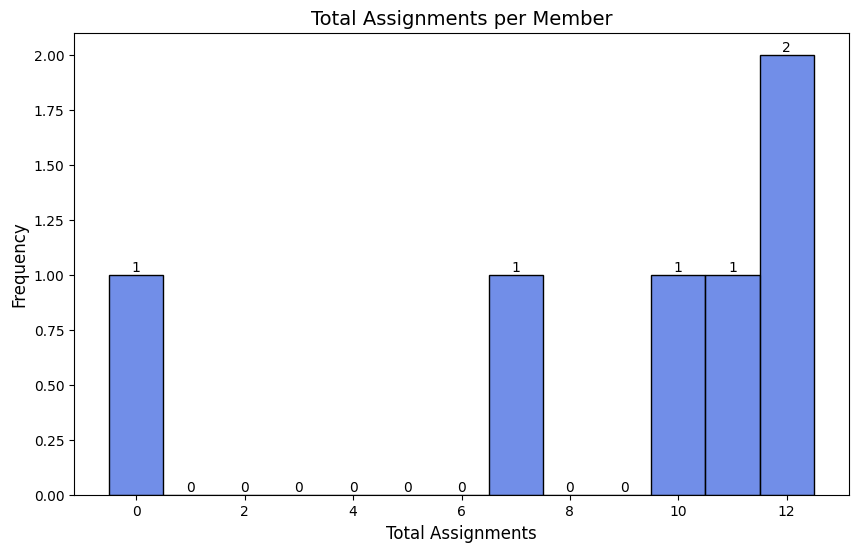


Solution 7


,Job,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12
0,Guitar,John,John,Jack,Jack,John,Jack,John,John,Jack,John,Jack,John,Jack
1,Piano,Jeff,Jeff,John,Jeff,Jeff,John,Jeff,Jeff,John,Jill,Jeff,Jeff,John
2,Leader,whee,whee,Jill,Jill,whee,whee,Jill,Jill,whee,whee,Jill,whee,whee
3,Waterboy,Jack,Jill,whee,whee,Jill,Jill,Jack,Jack,Jill,Jack,whee,Jack,Jill


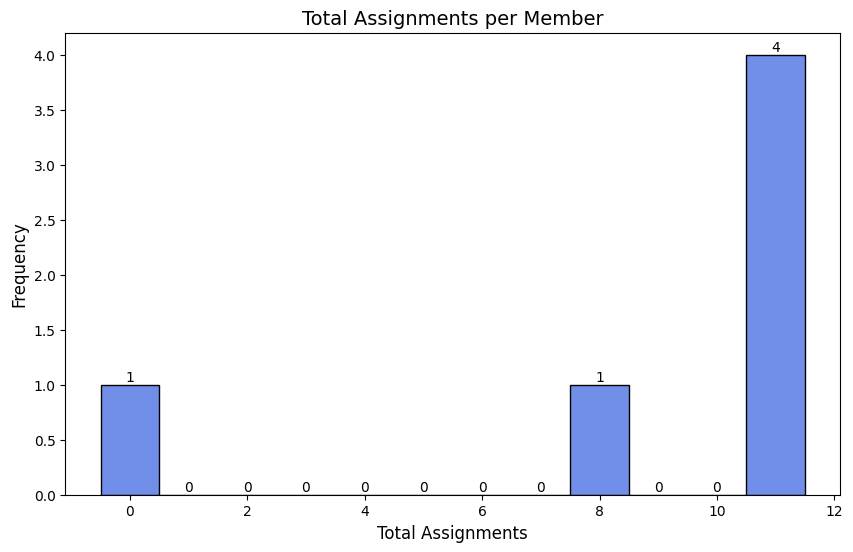


Statistics

Optimal solution found!


In [16]:
# Creates the model.
model = cp_model.CpModel()

# Creates job assignment variables.
shifts = {}
for m in all_members:
    for w in all_weeks:
        for j in all_jobs:
            shifts[(m, w, j)] = model.NewBoolVar(f"shift_m{m}_w{w}_j{j}")

# Each crucial job is assigned to exactly one member per week.
for w in all_weeks:
    for j in must_have_jobs:
        model.AddExactlyOne(shifts[(m, w, j)] for m in all_members)

# Each non-crucial job is assigned to at most one member per week.
for w in all_weeks:
    for j in not_must_have_jobs:
        model.AddAtMostOne(shifts[(m, w, j)] for m in all_members)

# Each member does at most one job per week.
for m in all_members:
    for w in all_weeks:
        model.AddAtMostOne(shifts[(m, w, j)] for j in all_jobs)

# Add availability constraints
for m in all_members:
    for w in all_weeks:
        if not availability_df.loc[m, w]: 
            for j in all_jobs:
                model.Add(shifts[(m, w, j)] == 0)

# Add skill constraints
for m in all_members:
    for j in all_jobs:
        if not skills_df.loc[m, j]: 
            for w in all_weeks:
                model.Add(shifts[(m, w, j)] == 0)
                
# Add constraint that members cannot be rostered thrice
for m in all_members:
    for w in range(len(all_weeks) - 2):  # Ensure we don't go out of bounds
        for j in all_jobs:
            model.Add(
                shifts[(m, w, j)] + shifts[(m, w + 1, j)] + shifts[(m, w + 2, j)] <= 2
            )


# Fairness constraint: Minimize variance in assignments
total_assignments = {}
for m in all_members:
    total_assignments[m] = model.NewIntVar(0, len(all_weeks) * len(all_jobs), f"total_assignments_{m}")
    model.Add(total_assignments[m] == sum(shifts[(m, w, j)] for w in all_weeks for j in all_jobs))

# Compute the mean assignments (rounded)
avg_assignments = len(all_weeks) * len(all_jobs) // len(all_members)

# Deviation from mean
deviation = {}
for m in all_members:
    deviation[m] = model.NewIntVar(0, len(all_weeks) * len(all_jobs), f"deviation_{m}")
    model.Add(deviation[m] >= total_assignments[m] - avg_assignments)
    model.Add(deviation[m] >= avg_assignments - total_assignments[m])

squared_deviation = {}
for m in all_members:
    squared_deviation[m] = model.NewIntVar(0, (len(all_weeks) * len(all_jobs)) ** 2, f"squared_deviation_{m}")
    model.AddMultiplicationEquality(squared_deviation[m], [deviation[m], deviation[m]])

# Minimize sum of squared deviations to reduce variance
model.Minimize(-sum(total_assignments[m] for m in all_members) * 10 + sum(squared_deviation[m] for m in all_members))
                


# Creates the solver and solve.
solver = cp_model.CpSolver()
solver.parameters.linearization_level = 0
solver.parameters.enumerate_all_solutions = False

solution_printer = JobPartialSolutionPrinter(
    shifts, all_members, NUM_WEEKS, all_jobs, total_assignments
)


status = solver.Solve(model, solution_printer)

# Statistics.
print("\nStatistics")
# Check if the optimal solution was found
if status == cp_model.OPTIMAL:
    print("\nOptimal solution found!")
elif status == cp_model.FEASIBLE:
    print("\nFeasible solution found, but not necessarily optimal.")
else:
    print("\nNo solution found.")
